The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


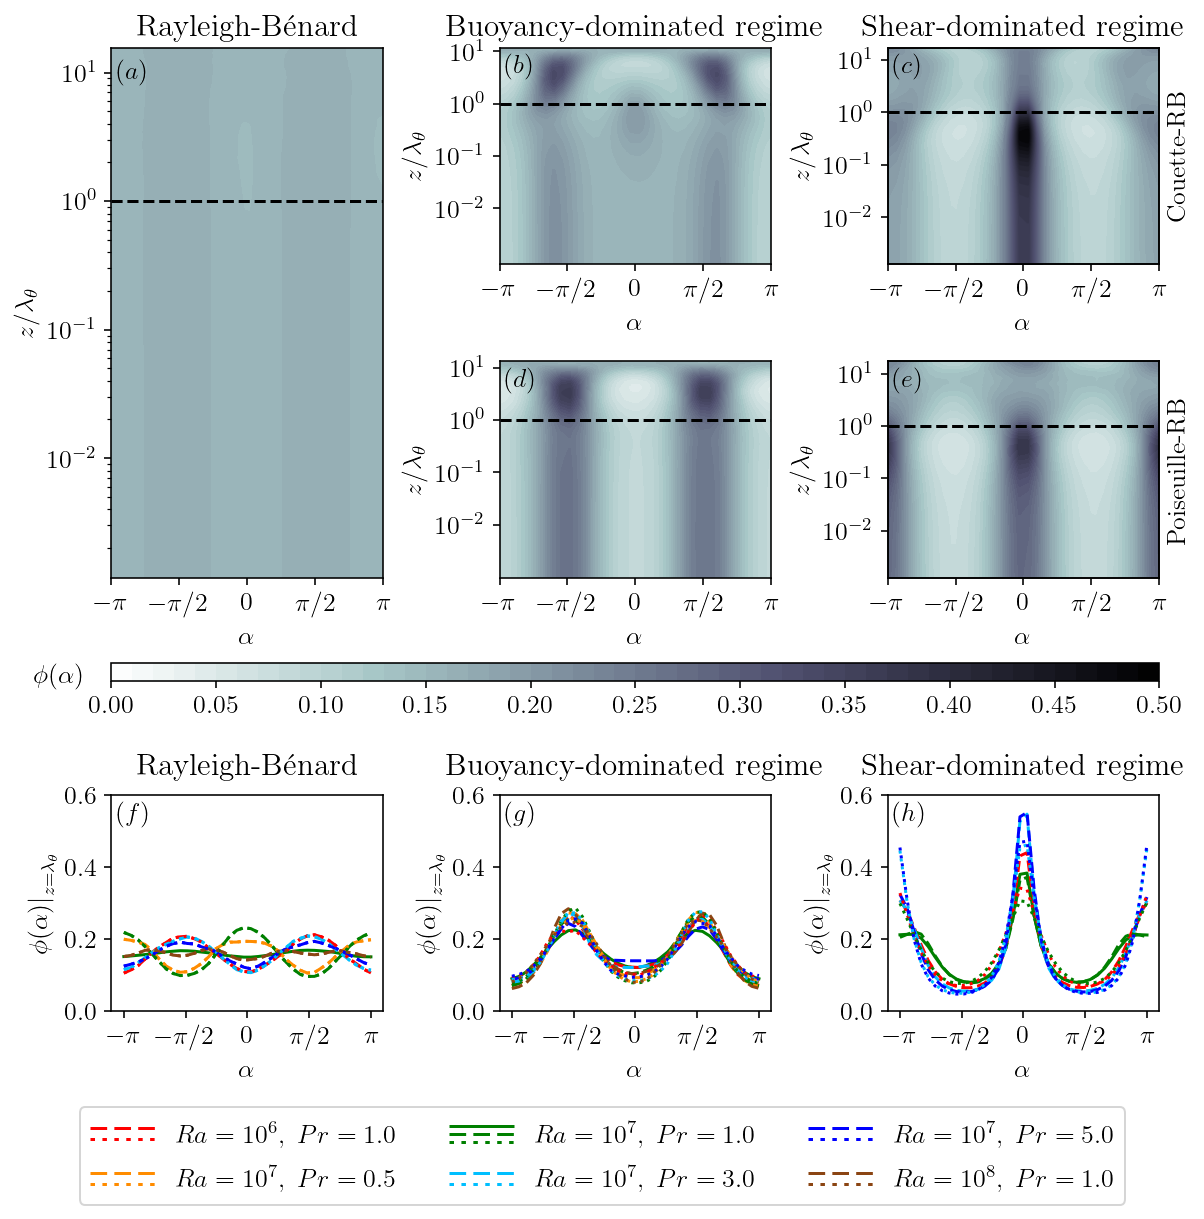

In [6]:
import os
import numpy as np
import scipy.interpolate as intp
import scipy.integrate as intg
import h5py
import matplotlib.pyplot as pl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerTuple,HandlerLineCollection
# from colormaps import rbw,baw
from matplotlib import rc

rc('font',**{'family':'STIXGeneral','serif':['stix']})
rc('text', usetex=True)
rc('font',**{'size':13})

class HandlerDashedLines(HandlerLineCollection):
    """
    Custom Handler for LineCollection instances.
    """
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[1] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines

def ISRE(foldername):
    if (foldername[:3]=='Re_'):
        return(True)
    else:
        return(False)

def GET_NU(folder,tavg=100):

    try:
        stafield = h5py.File('{}/stafield_master.h5'.format(folder),'r')
        xm = stafield['xm'][:]
        xm = np.pad(xm,(1,1),'constant',constant_values=(0,1))
        xc = stafield['xc'][:]
        avg_t = stafield['temp_m1'][0]
        tp_m1 = stafield['temp_m1'][:]/avg_t
        tp_m1 = np.pad(tp_m1,(0,1),'constant',constant_values=0)
        Nu = np.gradient(tp_m1,xc,edge_order=2)
        Nu = np.fabs(0.5*(Nu[0] + Nu[-1]))
        mean = Nu
        stdv = 0
    except Exception as e:
        data = np.genfromtxt('{}/nu_plate.out'.format(folder),comments='#')
        tavg = data[-1,0]-tavg
        data = data[data[:,0]>=tavg]
        time = data[:,0]
        data = data[:,1:3]
        data = np.mean(data,axis=1)
        mean = intg.trapz(data,x=time)/(time[-1]-time[0])
        stdv = (data-mean)**2
        stdv = intg.trapz(stdv,x=time)/(time[-1]-time[0])
        stdv = abs(stdv)**0.5
        stdv = (stdv/mean)*100

    return(mean)

fig = pl.figure(figsize=(8.25,7.5),constrained_layout=True)

gsp = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gsp[:2, 0])
ax2 = fig.add_subplot(gsp[0, 1])
ax3 = fig.add_subplot(gsp[0, 2])
ax4 = fig.add_subplot(gsp[1, 1])
ax5 = fig.add_subplot(gsp[1, 2])
ax6 = fig.add_subplot(gsp[2, 0])
ax7 = fig.add_subplot(gsp[2, 1])
ax8 = fig.add_subplot(gsp[2, 2])

alx = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
lcx = [0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02]
lcy = [0.94,0.88,0.88,0.88,0.88,0.88,0.88,0.88]
clr = ['k','k','k','k','k','k','k','k']

ax1.set_title('Rayleigh-Bénard')
ax2.set_title('Buoyancy-dominated regime')
ax3.set_title('Shear-dominated regime')

bx3 = ax3.twinx()
bx5 = ax5.twinx()

bx3.set_ylabel('Couette-RB')
bx5.set_ylabel('Poiseuille-RB')

bx3.set_yticks([])
bx5.set_yticks([])

alphabet = 'abcdefghijklmnopqrstuvwxyz'

for i,axi in enumerate(alx):
    axi.text(lcx[i],lcy[i],'$({})$'.format(alphabet[i]),transform=axi.transAxes,color=clr[i])

axs = [ax1,ax2,ax3,ax4,ax5]
Cases = [
    '../raw_data/CRB_Large/Ra1E+07_Pr1E+00/Ri_Inf',
    '../raw_data/CRB_Large/Ra1E+07_Pr1E+00/Ri_1E+00',
    '../raw_data/CRB_Large/Ra1E+07_Pr1E+00/Ri_1E-01',
    '../raw_data/PRB/Ra1E+07_Pr1E+00/Re_01414',
    '../raw_data/PRB/Ra1E+07_Pr1E+00/Re_10000'
]

maxes = []
minis = []

for Case,axi in zip(Cases,axs):

    dfl = Case + '/angle.h5'
    dat = h5py.File(dfl,'r')
    nus = GET_NU(Case)
    tbl = 0.5/nus
    img = axi.contourf(dat['bins'][:],dat['xm'][:]/tbl,dat['fluct'][:],levels=np.linspace(0,0.5,51),cmap='bone_r')
    for c in img.collections: c.set_edgecolor("face")
    axi.set_yscale('log')
    axi.set_yticks([1E-2,1E-1,1E0,1E1])
    axi.set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
    axi.set_xticklabels([r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
    axi.set_xlabel(r'$\alpha$')
    axi.set_ylabel(r'$z/\lambda_{\theta}$')
    axi.axhline(1,color='k',linestyle='--')
    maxes += [np.amax(dat['fluct'][:])]
    minis += [np.amin(dat['fluct'][:])]


cbr = pl.colorbar(img,ax=fig.axes[:5],orientation='horizontal',aspect=60,pad=0.025)
cbr.ax.set_xticks(np.linspace(0,0.5,11))
cbr.ax.set_xlabel(r'$\phi(\alpha)$'+'\n\n')
cbr.ax.xaxis.set_label_coords(-0.05, 1)

Buoys  = [
    '../raw_data/CRB_Large/Ra1E+07_Pr1E+00/Ri_Inf',
    '../raw_data/RBP/Ra1E+06_Pr1E+00',
    '../raw_data/RBP/Ra1E+07_Pr5E-01',
    '../raw_data/RBP/Ra1E+07_Pr1E+00',
    '../raw_data/RBP/Ra1E+07_Pr3E+00',
    '../raw_data/RBP/Ra1E+07_Pr5E+00',
    '../raw_data/RBP/Ra1E+08_Pr1E+00',
    '../raw_data/RBP/Ra1E+06_Pr1E+00',
    '../raw_data/RBP/Ra1E+07_Pr5E-01',
    '../raw_data/RBP/Ra1E+07_Pr1E+00',
    '../raw_data/RBP/Ra1E+07_Pr3E+00',
    '../raw_data/RBP/Ra1E+07_Pr5E+00',
    '../raw_data/RBP/Ra1E+08_Pr1E+00'
]

Trans  = [
    '../raw_data/CRB_Large/Ra1E+07_Pr1E+00/Ri_5E+00',
    '../raw_data/CRB/Ra1E+06_Pr1E+00/Re_00400',
    '../raw_data/CRB/Ra1E+07_Pr5E-01/Re_02000',
    '../raw_data/CRB/Ra1E+07_Pr1E+00/Re_01414',
    '../raw_data/CRB/Ra1E+07_Pr3E+00/Re_00700',
    '../raw_data/CRB/Ra1E+07_Pr5E+00/Re_00500',
    '../raw_data/CRB/Ra1E+08_Pr1E+00/Re_05000',
    '../raw_data/PRB/Ra1E+06_Pr1E+00/Re_00400',
    '../raw_data/PRB/Ra1E+07_Pr5E-01/Re_02000',
    '../raw_data/PRB/Ra1E+07_Pr1E+00/Re_01414',
    '../raw_data/PRB/Ra1E+07_Pr3E+00/Re_00700',
    '../raw_data/PRB/Ra1E+07_Pr5E+00/Re_00500',
    '../raw_data/PRB/Ra1E+08_Pr1E+00/Re_05000'
]

Shears = [
    '../raw_data/CRB_Large/Ra1E+07_Pr1E+00/Ri_1E-01',
    '../raw_data/CRB/Ra1E+06_Pr1E+00/Re_10000',
    '../raw_data/CRB/Ra1E+07_Pr5E-01/Re_10000',
    '../raw_data/CRB/Ra1E+07_Pr1E+00/Re_10000',
    '../raw_data/CRB/Ra1E+07_Pr3E+00/Re_10000',
    '../raw_data/CRB/Ra1E+07_Pr5E+00/Re_10000',
    '../raw_data/CRB/Ra1E+08_Pr1E+00/Re_10000',
    '../raw_data/PRB/Ra1E+06_Pr1E+00/Re_10000',
    '../raw_data/PRB/Ra1E+07_Pr5E-01/Re_10000',
    '../raw_data/PRB/Ra1E+07_Pr1E+00/Re_10000',
    '../raw_data/PRB/Ra1E+07_Pr3E+00/Re_10000',
    '../raw_data/PRB/Ra1E+07_Pr5E+00/Re_10000',
    '../raw_data/PRB/Ra1E+08_Pr1E+00/Re_10000',
]

Colors = ['g','r','darkorange','g','deepskyblue','b','saddlebrown','r','darkorange','g','deepskyblue','b','saddlebrown']
Lines  = ['-','--','--','--','--','--','--',':',':',':',':',':',':']

for Buoy,Tran,Shear,Color,Line in zip(Buoys,Trans,Shears,Colors,Lines):

    sta = Buoy + '/stafield_master.h5'
    sta = h5py.File(sta,'r')
    pra = sta['Prandtl Number'][0]
    try:
        rey = sta['Wall Reynolds Number'][0]
    except:
        rey = sta['Bulk Reynolds Number'][0]

    dfl = Buoy + '/angle.h5'
    dat = h5py.File(dfl,'r')
    nus = GET_NU(Buoy)
    nu0 = nus
    rl0 = 3.9246*(nu0**2)/(pra**(2/3))
    tbl = 0.5/nus
    bns = dat['bins'][:]
    xms = dat['xm'][:]
    pdf = dat['fluct'][:]
    pdf = intp.interp1d(xms,pdf,axis=0,kind='cubic')
    pdf = pdf(tbl)
    plt = ax6.plot(bns,pdf,color=Color,linestyle=Line)
    ax6.set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
    ax6.set_xticklabels([r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
    ax6.set_ylim(0,0.6)
    ax6.set_xlabel(r'$\alpha$')
    ax6.set_ylabel(r'$\left.\phi(\alpha)\right|_{z=\lambda_{\theta}}$')
    ax6.set_title('Rayleigh-Bénard',pad=10.0)
    
    sta = Tran + '/stafield_master.h5'
    sta = h5py.File(sta,'r')
    try:
        rey = sta['Wall Reynolds Number'][0]
    except:
        rey = sta['Bulk Reynolds Number'][0]

    dfl = Tran + '/angle.h5'
    dat = h5py.File(dfl,'r')
    nus = GET_NU(Tran)
    rlt = rey/rl0
    tbl = 0.5/nus
    bns = dat['bins'][:]
    xms = dat['xm'][:]
    pdf = dat['fluct'][:]
    pdf = intp.interp1d(xms,pdf,axis=0,kind='cubic')
    pdf = pdf(tbl)
    plt = ax7.plot(bns,pdf,color=Color,linestyle=Line)
    ax7.set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
    ax7.set_xticklabels([r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
    ax7.set_ylim(0,0.6)
    ax7.set_xlabel(r'$\alpha$')
    ax7.set_ylabel(r'$\left.\phi(\alpha)\right|_{z=\lambda_{\theta}}$')
    ax7.set_title('Buoyancy-dominated regime',pad=10.0)

    sta = Shear + '/stafield_master.h5'
    sta = h5py.File(sta,'r')
    try:
        rey = sta['Wall Reynolds Number'][0]
    except:
        rey = sta['Bulk Reynolds Number'][0]

    dfl = Shear + '/angle.h5'
    dat = h5py.File(dfl,'r')
    nus = GET_NU(Shear)
    rls = rey/rl0
    tbl = 0.5/nus
    bns = dat['bins'][:]
    xms = dat['xm'][:]
    pdf = dat['fluct'][:]
    pdf = intp.interp1d(xms,pdf,axis=0,kind='cubic')
    pdf = pdf(tbl)
    if (rls>10):
        plt = ax8.plot(bns,pdf,color=Color,linestyle=Line)
    ax8.set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
    ax8.set_xticklabels([r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
    ax8.set_ylim(0,0.6)
    ax8.set_xlabel(r'$\alpha$')
    ax8.set_ylabel(r'$\left.\phi(\alpha)\right|_{z=\lambda_{\theta}}$')
    ax8.set_title('Shear-dominated regime',pad=10.0)

handles = []
labels  = [r'$Ra= 10^6, \ Pr = 1.0$',r'$Ra= 10^7, \ Pr = 0.5$',r'$Ra= 10^7, \ Pr = 1.0$',r'$Ra= 10^7, \ Pr = 3.0$',r'$Ra= 10^7, \ Pr = 5.0$',r'$Ra= 10^8, \ Pr = 1.0$']

for i in range(1,7):
    if (i==3):
        line = [[(0, 0)]]
        styles = [Lines[0],Lines[i],Lines[i+6]]
        colors = [Colors[0],Colors[i],Colors[i+6]]
        handles += [LineCollection(3 * line, linestyles=styles, colors=colors)]
    else:
        line = [[(0, 0)]]
        styles = [Lines[i],Lines[i+6]]
        colors = [Colors[i],Colors[i+6]]
        handles += [LineCollection(2 * line, linestyles=styles, colors=colors)]

pl.figlegend(handles,labels,loc='lower center',bbox_to_anchor=(0.5,-0.12),ncol=3,handler_map={type(handles[0]): HandlerDashedLines()},handlelength=2.5,handleheight=1.5)

# pl.savefig('PdF.png',bbox_inches='tight')
# pl.savefig('PdF.pdf',bbox_inches='tight')
# pl.savefig('PdF.eps',bbox_inches='tight')
pl.show()
